In [1]:
import os
import time
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import norm, pearsonr, spearmanr
from scipy.spatial import distance
### 绘图包
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42 # 输出PDF文字可编辑
# 机器学习packages
import sklearn #collection of machine learning algorithms
#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve
import shap
from sklearn.metrics import roc_curve, auc
#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn import linear_model
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
print("scikit-learn version: {}". format(sklearn.__version__))
### 其他
import cloudpickle as pickle
from biom import load_table
import warnings
warnings.filterwarnings("ignore") # 报错提示
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' #last_expr

scikit-learn version: 1.0.2


In [2]:
data = pd.read_csv('../Data/2.modelData_new.csv')
#使用平均值补齐
data = data.fillna(data.mean())  # 对特征使用均值填充
select_cols=data.columns[2:11]
X=data.loc[:,select_cols]
y=data['DiagSepsis']
X.head(2)

,心率_次/分,中性粒细胞绝对值_×10^9/L,白细胞计数_×10^9/L,白球比例_NULL,天门冬氨酸氨基转移酶_U/L,钙_mmol/L,γ-谷氨酰基转移酶_U/L,超敏C反应蛋白_mg/L,前白蛋白_mg/L
0,132.0,27.35,31.63,1.11,23.0,2.40,14.0,167.70,93.0
1,98.0,2.68,5.27,1.76,27.0,2.44,12.0,0.43,208.0


In [3]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, 
                                                                    test_size = 0.4, 
                                                                    random_state = 0,
                                                                    stratify=y)
X_train.shape, X_test.shape
print("----------train set---------")
y_train.value_counts()
print("----------test set---------")
y_test.value_counts()

((445, 9), (298, 9))

----------train set---------


0    258
1    187
Name: DiagSepsis, dtype: int64

----------test set---------


0    172
1    126
Name: DiagSepsis, dtype: int64

In [4]:
rfc = ensemble.RandomForestClassifier(n_estimators= 200, max_features=0.3, max_samples=0.5, max_depth=3, 
                                      class_weight='balanced', random_state=0)
rfc.fit(X_train, y_train)
rfc.score(X_train, y_train) # Accuracy
rfc.score(X_test, y_test) # Accuracy

RandomForestClassifier(class_weight='balanced', max_depth=3, max_features=0.3,
                       max_samples=0.5, n_estimators=200, random_state=0)

0.8584269662921349

0.8523489932885906

## 学习曲线

In [5]:
# 设置交叉验证分组
cv_split = model_selection.StratifiedShuffleSplit(n_splits=10, test_size=.2, random_state=0)

In [6]:
# 计算学习曲线数据
train_sizes, train_scores, test_scores = learning_curve(rfc, 
                                                        X_train, 
                                                        y_train, 
                                                        cv=cv_split, 
                                                        n_jobs=-1, 
                                                        train_sizes=np.linspace(0.1, 1.0, 10))

# 计算训练和验证的平均得分
train_mean = np.mean(train_scores, axis=1)
train_mean
test_mean = np.mean(test_scores, axis=1)
test_mean

array([0.95714286, 0.91267606, 0.9       , 0.89014085, 0.8758427 ,
       0.86244131, 0.86947791, 0.86514085, 0.8609375 , 0.85449438])

array([0.79101124, 0.82359551, 0.83483146, 0.83483146, 0.83258427,
       0.84157303, 0.84044944, 0.83595506, 0.83258427, 0.83370787])

In [7]:
# 计算训练和验证得分的标准差
train_std = np.std(train_scores, axis=1)
test_std = np.std(test_scores, axis=1)

<Figure size 576x432 with 0 Axes>

Text(0.5, 1.0, 'Learning Curve for Random Forest Classifier')

Text(0.5, 0, 'Training Set Size')

Text(0, 0.5, 'Accuracy')

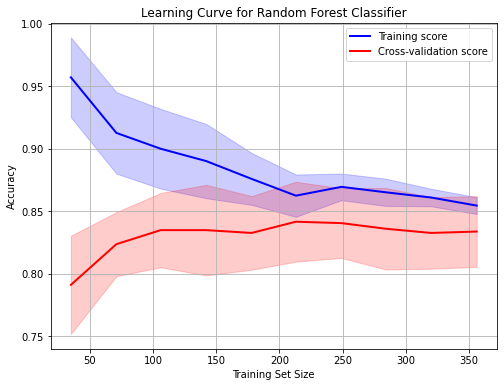

In [8]:
# 绘制学习曲线
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label='Training score', color='b', lw=2)
plt.plot(train_sizes, test_mean, label='Cross-validation score', color='r', lw=2)

# 填充标准差区域
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='b', alpha=0.2)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='r', alpha=0.2)

# 添加图形标签
plt.title('Learning Curve for Random Forest Classifier')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
#plt.savefig('../Results/2.LearingCurve_new.pdf',bbox_inches = 'tight')
# 显示图形
plt.show()

## Feature importance

In [9]:
# Calculate the importance of variables
random_forest_importance=list(rfc.feature_importances_)
random_forest_feature_importance=[(feature,round(importance,3)) 
                                  for feature, importance in zip(X_train.columns,random_forest_importance)]
random_forest_feature_importance=sorted(random_forest_feature_importance,key=lambda x:x[1],reverse=True)
feature_importance = [(key, value) for key, value in random_forest_feature_importance if value != 0]

In [10]:
len(feature_importance)
keys, values = zip(*feature_importance)
feature_imp=pd.DataFrame({'Variable':keys,
                         'Importance':values})
feature_imp

9

,Variable,Importance
0,超敏C反应蛋白_mg/L,0.308
1,中性粒细胞绝对值_×10^9/L,0.197
2,白球比例_NULL,0.155
3,天门冬氨酸氨基转移酶_U/L,0.111
4,白细胞计数_×10^9/L,0.072
5,前白蛋白_mg/L,0.069
6,钙_mmol/L,0.039
7,心率_次/分,0.028
8,γ-谷氨酰基转移酶_U/L,0.021


<Figure size 576x720 with 0 Axes>

<AxesSubplot:xlabel='Importance', ylabel='Variable'>

Text(0, 0.5, 'Variable')

Text(0.5, 0, 'Importance')

Text(0.5, 1.0, 'Variable Importances')

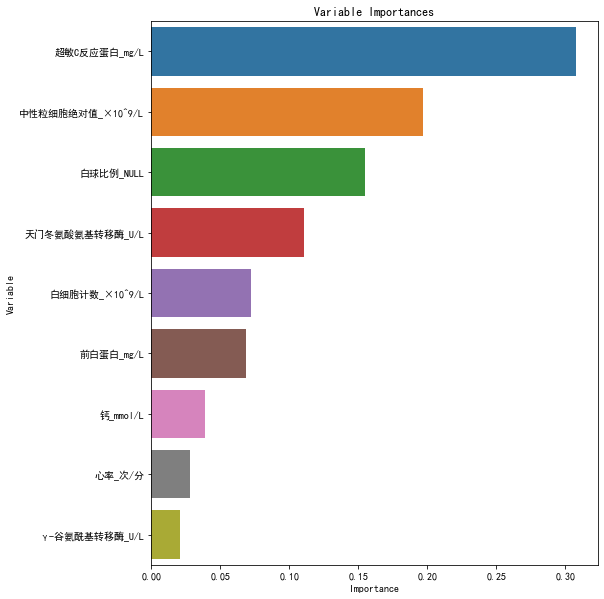

In [11]:
# Calculate the importance of variables
plt.rcParams['font.sans-serif']=['SimHei'] #显示中文
plt.figure(figsize=(8, 10))
sns.barplot(x='Importance',y='Variable',data=feature_imp)
plt.ylabel('Variable')
plt.xlabel('Importance')
plt.title('Variable Importances')
#plt.savefig('../Results/2.1ModelImportance_new.pdf',bbox_inches = 'tight')

## Shap

RandomForestClassifier(class_weight='balanced', max_depth=3, max_features=0.3,
                       max_samples=0.5, n_estimators=200, random_state=0)

X_train shape: (445, 9)
shap_values shape: (2, 445, 9)
shap_values_class1 shape: (445, 9)


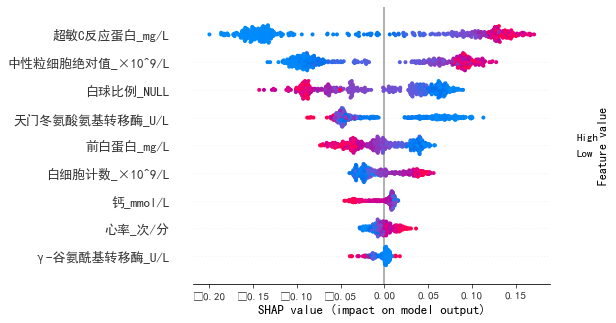

In [9]:
rfc.fit(X_train, y_train)
print("X_train shape:", X_train.shape)
explainer = shap.TreeExplainer(rfc)
shap_values = explainer.shap_values(X_train)
print("shap_values shape:", np.array(shap_values).shape) 
shap_values_class1 =np.array(shap_values)[1,:]
print("shap_values_class1 shape:", shap_values_class1.shape) 
plt.rcParams['font.sans-serif']=['SimHei'] #显示中文
shap.summary_plot(shap_values_class1, X_train, show=False)
#plt.savefig('../Results/2.2trainShap_new.pdf', format='pdf')
plt.show()

In [10]:
# 获取列名列表
feature_names = X_train.columns.tolist()
# 或者直接使用 X_train.columns
print(X_train.columns)

Index(['心率_次/分', '中性粒细胞绝对值_×10^9/L', '白细胞计数_×10^9/L', '白球比例_NULL',
       '天门冬氨酸氨基转移酶_U/L', '钙_mmol/L', 'γ-谷氨酰基转移酶_U/L', '超敏C反应蛋白_mg/L',
       '前白蛋白_mg/L'],
      dtype='object')


In [11]:
new_patient = {
    '心率_次/分': 102,
    '中性粒细胞绝对值_×10^9/L': 0.52,
    '白细胞计数_×10^9/L': 1.31,
    '白球比例_NULL': 1.59,
    '天门冬氨酸氨基转移酶_U/L': 25,
    '钙_mmol/L': 2.22,
    'γ-谷氨酰基转移酶_U/L': 12,
    '超敏C反应蛋白_mg/L': 112.27,
    '前白蛋白_mg/L': 114.8
}
X_vali=pd.DataFrame([new_patient])
X_vali

,心率_次/分,中性粒细胞绝对值_×10^9/L,白细胞计数_×10^9/L,白球比例_NULL,天门冬氨酸氨基转移酶_U/L,钙_mmol/L,γ-谷氨酰基转移酶_U/L,超敏C反应蛋白_mg/L,前白蛋白_mg/L
0,102,0.52,1.31,1.59,25,2.22,12,112.27,114.8


In [12]:
shap_values_sig1 = explainer.shap_values(X_vali)
print("shap_values shape:", [sv.shape for sv in shap_values_sig1]) 
shap_vsig1 =np.array(shap_values_sig1)[1,:]
print("shap_values_class1 shape:", shap_vsig1.shape) 
X_vali.iloc[0,:]
# 可视化第一个prediction的解释
shap.initjs()

shap_values shape: [(1, 9), (1, 9)]
shap_values_class1 shape: (1, 9)


心率_次/分              102.00
中性粒细胞绝对值_×10^9/L      0.52
白细胞计数_×10^9/L         1.31
白球比例_NULL             1.59
天门冬氨酸氨基转移酶_U/L       25.00
钙_mmol/L              2.22
γ-谷氨酰基转移酶_U/L        12.00
超敏C反应蛋白_mg/L        112.27
前白蛋白_mg/L           114.80
Name: 0, dtype: float64

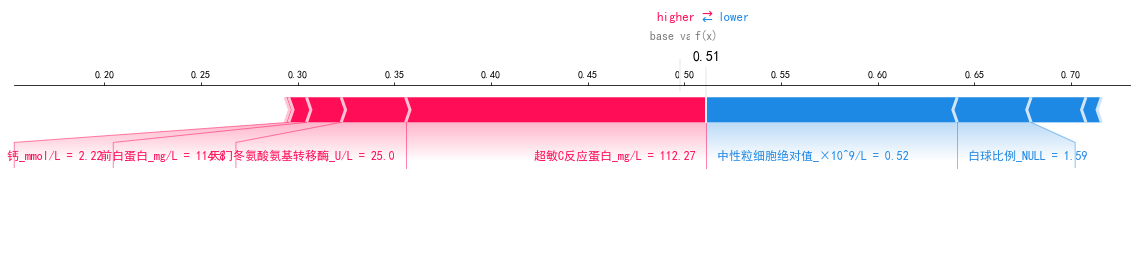

meta NOT subset; don't know how to subset; dropped


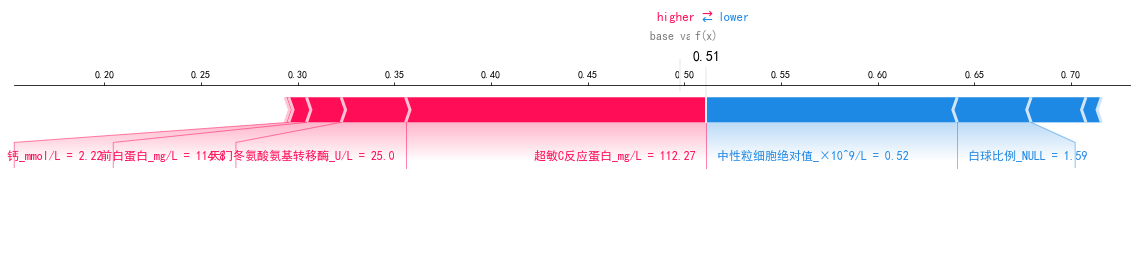

In [13]:
#explainer.expected_value[1]根据需要调整
shap.force_plot(explainer.expected_value[1], shap_vsig1[0,:], X_vali.iloc[0,:], matplotlib=True,show=False)
plt.savefig('../Results/1.4 valiShap2.pdf',format='pdf')

## Leave one out

In [13]:
# 计算 X_train 的各列的均值
mean_values = X_train.mean()
mean_values

心率_次/分              116.847712
中性粒细胞绝对值_×10^9/L      8.476683
白细胞计数_×10^9/L        12.910719
白球比例_NULL             1.615134
天门冬氨酸氨基转移酶_U/L       51.493309
钙_mmol/L              2.359561
γ-谷氨酰基转移酶_U/L        54.702321
超敏C反应蛋白_mg/L         43.508270
前白蛋白_mg/L           145.080529
dtype: float64

In [14]:
# 函数：替换指定列数的 数据集并计算 ROC 曲线
from scipy import interp
from scipy.stats import sem, t
import random
def replace_and_plot_roc(num_cols_to_replace, n_runs=10, alpha=0.95):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    for i in range(n_runs):
        X_test_copy = X_test.copy()
        cols_to_replace = random.sample(range(X_test.shape[1]), num_cols_to_replace)
        X_test_copy.iloc[:, cols_to_replace] = mean_values[cols_to_replace]
        
        y_pred_proba = rfc.predict_proba(X_test_copy)
        fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba[:, 1], pos_label=1)
        roc_auc = metrics.auc(fpr, tpr)
        aucs.append(roc_auc)
        
        interp_tpr = interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
    
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    
    # 计算 AUC 的95% CI
    auc_mean = np.mean(aucs)
    auc_ci = t.interval(alpha, len(aucs)-1, loc=auc_mean, scale=sem(aucs))
    
    # 计算置信区间
    ci_tprs = []
    for i in range(len(mean_fpr)):
        ci = t.interval(alpha, len(tprs)-1, loc=np.mean([tpr[i] for tpr in tprs]), scale=sem([tpr[i] for tpr in tprs]))
        ci_tprs.append(ci)
    
    lower_ci = [ci[0] for ci in ci_tprs]
    upper_ci = [ci[1] for ci in ci_tprs]
    
    return mean_fpr, mean_tpr, auc_mean, auc_ci, lower_ci, upper_ci

<Figure size 576x576 with 0 Axes>

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'ROC Curve with Column Replacement')

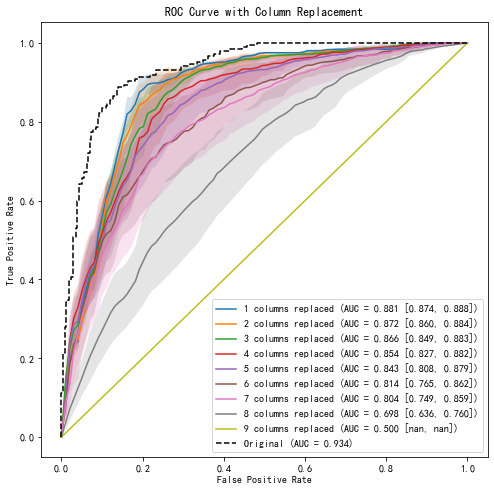

In [15]:
# 初始化绘图
plt.figure(figsize=(8, 8))

# 绘制不同列数替换的平均 ROC 曲线及 95% CI
for i in range(1, X_train.shape[1] + 1):
    mean_fpr, mean_tpr, mean_auc,auc_ci, lower_ci, upper_ci = replace_and_plot_roc(i)
    plt.plot(mean_fpr, mean_tpr, 
             label=f'{i} columns replaced (AUC = {mean_auc:.3f} [{auc_ci[0]:.3f}, {auc_ci[1]:.3f}])')
    plt.fill_between(mean_fpr, lower_ci, upper_ci, alpha=0.2)

# 绘制基线 ROC 曲线（原始数据）
y_pred_proba_original = rfc.predict_proba(X_train)
fpr_original, tpr_original, _ = metrics.roc_curve(y_train, y_pred_proba_original[:, 1], pos_label=1)
roc_auc_original = metrics.auc(fpr_original, tpr_original)
plt.plot(fpr_original, tpr_original, 
         label=f'Original (AUC = {roc_auc_original:.3f})', 
         color='black', linestyle='--')

# 设置图例和轴标签
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Column Replacement')
plt.legend(loc='lower right')
#plt.savefig('../Results/2.3ROC_replace_new.pdf',bbox_inches = 'tight')
plt.show()

<Figure size 576x576 with 0 Axes>

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'ROC Curve with Column Replacement')

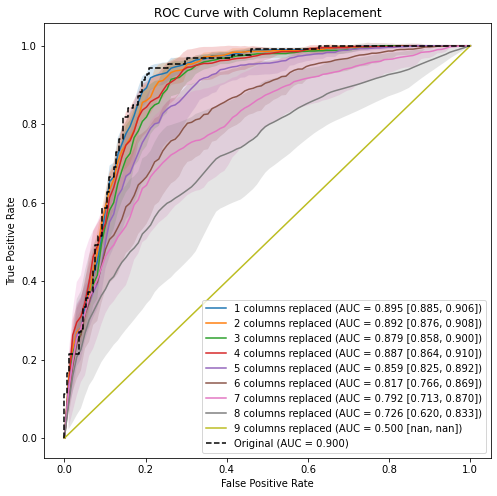

In [15]:
# 初始化绘图
plt.figure(figsize=(8, 8))

# 绘制不同列数替换的平均 ROC 曲线及 95% CI
for i in range(1, X_train.shape[1] + 1):
    mean_fpr, mean_tpr, mean_auc,auc_ci, lower_ci, upper_ci = replace_and_plot_roc(i)
    plt.plot(mean_fpr, mean_tpr, 
             label=f'{i} columns replaced (AUC = {mean_auc:.3f} [{auc_ci[0]:.3f}, {auc_ci[1]:.3f}])')
    plt.fill_between(mean_fpr, lower_ci, upper_ci, alpha=0.2)

# 绘制基线 ROC 曲线（原始数据）
y_pred_proba_original = rfc.predict_proba(X_test)
fpr_original, tpr_original, _ = metrics.roc_curve(y_test, y_pred_proba_original[:, 1], pos_label=1)
roc_auc_original = metrics.auc(fpr_original, tpr_original)
plt.plot(fpr_original, tpr_original, 
         label=f'Original (AUC = {roc_auc_original:.3f})', 
         color='black', linestyle='--')

# 设置图例和轴标签
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Column Replacement')
plt.legend(loc='lower right')
plt.savefig('../Results/2.3ROC_replace_test_new.pdf',bbox_inches = 'tight')
plt.show()

## validation

In [21]:
vali=pd.read_excel('../Data/validation_labeled.xlsx')
vali.shape
vali.head(2)

(200, 60)

,住院号,DiagSepsis,Year,出院诊断,性别,年龄_month,呼吸_次/分,体温_℃,体重_kg,心率_次/分,...,磷_mmol/L,总胆汁酸_μmol/L,总胆红素_μmol/L,甘油三脂_mmol/L,总蛋白_g/L,尿酸_μmol/L,脂肪酶_U/L,淀粉酶_U/L,超敏C反应蛋白_mg/L,前白蛋白_mg/L
0,60171825,1,2019,先天性胆总管囊肿,女,28,24.0,38.2,11.5,142.0,...,1.64,11.0,6.0,0.77,67.3,88.0,290.7,NaN,186.45,0.106
1,60188573,1,2019,急性坏疽性阑尾炎伴穿孔,女,81,24.0,37.4,17.3,100.0,...,1.78,2.2,16.8,0.84,70.8,293.0,9.2,NaN,57.29,0.151


In [22]:
select_cols
df=vali.loc[:,select_cols]
df['DiagSepsis']=vali['DiagSepsis']
df=df.fillna(data.mean())  # 对特征使用均值填充
df.shape

Index(['心率_次/分', '中性粒细胞绝对值_×10^9/L', '白细胞计数_×10^9/L', '白球比例_NULL',
       '天门冬氨酸氨基转移酶_U/L', '钙_mmol/L', 'γ-谷氨酰基转移酶_U/L', '超敏C反应蛋白_mg/L',
       '前白蛋白_mg/L'],
      dtype='object')

(200, 10)

In [23]:
X_vali=df.loc[:,select_cols]
X_vali.head(4)
y_vali=df['DiagSepsis']
X_vali.shape

,心率_次/分,中性粒细胞绝对值_×10^9/L,白细胞计数_×10^9/L,白球比例_NULL,天门冬氨酸氨基转移酶_U/L,钙_mmol/L,γ-谷氨酰基转移酶_U/L,超敏C反应蛋白_mg/L,前白蛋白_mg/L
0,142.0,5.99,8.09,1.08,165.0,2.17,230.0,186.450000,0.106
1,100.0,2.15,2.92,1.51,35.0,2.32,11.0,57.290000,0.151
2,100.0,7.00,8.49,1.28,23.0,2.45,17.0,8.790000,0.309
3,122.0,14.89,17.86,1.88,31.0,2.56,13.0,43.790216,0.231


(200, 9)

0.9066033469018543

<Figure size 432x432 with 0 Axes>

Text(0.5, 1.0, 'Validation ROC')

(-0.05, 1.05)

(-0.05, 1.05)

Text(0.5, 0, '1-Specificity')

Text(0, 0.5, 'Sensitivity')

meta NOT subset; don't know how to subset; dropped


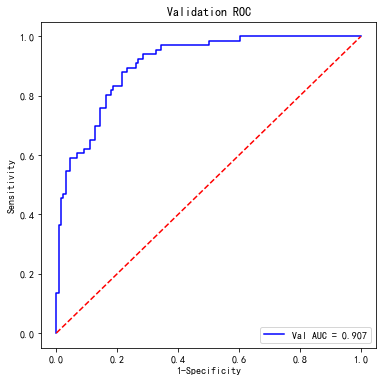

In [24]:
vpred = rfc.predict_proba(X_vali)[:,1]
#############画图部分
fpr, tpr, threshold = metrics.roc_curve(y_vali, vpred)
roc_auc = auc(fpr, tpr)
roc_auc
plt.figure(figsize=(6,6))
plt.title('Validation ROC')
plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.05])  # 设置x、y轴的上下限，以免和边缘重合，更好的观察图像的整体
plt.ylim([-0.05, 1.05])
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.savefig('../Results/1.3.innerValiROC.pdf',bbox_inches = 'tight')
plt.show()

In [26]:
# 计算原始AUC
from sklearn.utils import resample
pred = rfc.predict_proba(X_vali)[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_vali, pred)
roc_auc = auc(fpr, tpr)
print('roc_auc:', roc_auc)

# 自助法（Bootstrap）计算AUC的95%置信区间
n_iterations = 100
auc_scores = []

for i in range(n_iterations):
    # 随机抽样（有放回）
    X_resample, y_resample = resample(X_vali, y_vali, random_state=i)
    #rfc.fit(X_resample, y_resample)
    y_pred_prob_resample = rfc.predict_proba(X_resample)[:, 1]
    fpr, tpr, threshold = metrics.roc_curve(y_resample, y_pred_prob_resample)
    auc_resample=auc(fpr, tpr)
    auc_scores.append(auc_resample)

# 计算置信区间
auc_lower = np.percentile(auc_scores, 2.5)
auc_upper = np.percentile(auc_scores, 97.5)

print(f"95% CI for AUC: ({auc_lower}, {auc_upper})")

roc_auc: 0.9066033469018543
95% CI for AUC: (0.8599141400257324, 0.9367902612636361)


In [27]:
vali['predicteScore']=vpred
vali.to_csv('../Data/vali_diag.csv', index=None)